# The hidden cut algorithm for locating unentanglement

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from scipy.stats import unitary_group

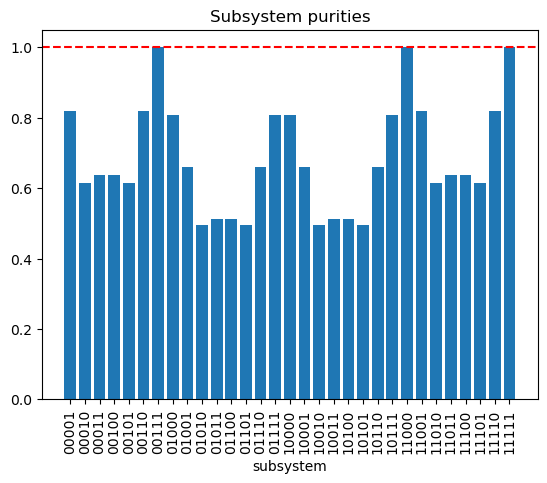

In [75]:
def random_state(dim):
    return unitary_group.rvs(dim)[0]

def separable_state(*sizes):
    state = np.array([1])
    for n in sizes:
        component = random_state(2**n)
        state = np.kron(state, component)
    return state

state = separable_state(2, 3)
n = int(np.log2(len(state)))

dev = qml.device('default.qubit')

@qml.qnode(dev)
def purity(state, qubits):
    qml.StatePrep(state, wires=range(n))
    return qml.purity(wires=qubits)

# p = purity(state, qubits=[0,1])

@qml.qnode(dev)
def density_matrix(state, qubits):
    qml.StatePrep(state, wires=range(n))
    return qml.density_matrix(qubits)

# rho = density_matrix(state, [0,1])
# np.trace(rho @ rho).round(5).item()

bitstrings = []
purities = []

for x in range(1, len(state)):
    bitstring = [int(bit) for bit in bin(x)[2:].zfill(n)]
    subsystem = [i for i in range(n) if bitstring[i] == 1]
    bitstrings.append(''.join(str(bit) for bit in bitstring))
    purities.append(purity(state, subsystem))

plt.bar(bitstrings, purities)
plt.xticks(rotation=90)
plt.axhline(y=1.0, color='r', ls='--')
plt.xlabel('subsystem')
plt.title('Subsystem purities')
plt.show()

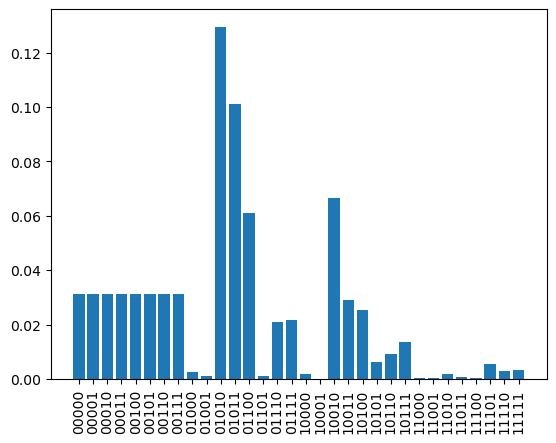

In [166]:
t = 1
total_qubits = (2*t + 1) * n
# dev = qml.device('lightning.qubit', shots=100, wires=n_qubits)
dev = qml.device('default.qubit', shots=100)

@qml.qnode(dev)
def hidden_cut_circuit(state):
    # Create copies of state
    for pair in range(t):
        for copy in range(2):
            offset = n + 2 * n * pair + n * copy
            qml.StatePrep(state, wires=range(offset, offset + n))
                            
    # Hadamard transform
    for wire in range(n):
        qml.Hadamard(wires=wire)

    # Controlled swaps
    for c in range(n):
        for pair in range(t):
            a = c + n + 2*n*pair
            b = c + n + 2*n*pair + n
            qml.ctrl(qml.SWAP, c, control_values=1)(wires=(a,b))

    qml.Snapshot('after_swaps', qml.density_matrix(range(n)))

    # Hadamard transform
    for wire in range(0, n):
        qml.Hadamard(wires=wire)

    # Measure
    qml.Snapshot('final', qml.density_matrix(range(n)))
    return qml.sample(wires=range(n))

snapshots = qml.snapshots(hidden_cut_circuit)(state)
rho_after_swaps = snapshots['after_swaps']
evals, evecs = np.linalg.eig(rho_after_swaps)
probs = np.abs(evecs[1])**2
bitstrings = [bin(x)[2:].zfill(n) for x in range(2**n)]

plt.bar(bitstrings, probs)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# why does this work for a single pair??